In [171]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import os
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split,RepeatedKFold,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone

from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Hotel1 and Hotel2 data is seggregated into two different csv files

In [34]:
## Reading the Hotel1 data
train_df = pd.read_csv('hotel-modelling-master/H1.csv')

train_df.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,2017,August,35,31,2,8,2,1,...,No Deposit,143,NULL,0,Transient,89.75,0,0,Check-Out,2017-09-10
40056,0,169,2017,August,35,30,2,9,2,0,...,No Deposit,250,NULL,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10
40057,0,204,2017,August,35,29,4,10,2,0,...,No Deposit,250,NULL,0,Transient,153.57,0,3,Check-Out,2017-09-12
40058,0,211,2017,August,35,31,4,10,2,0,...,No Deposit,40,NULL,0,Contract,112.80,0,1,Check-Out,2017-09-14


In [35]:
## Checking the datatypes of the columns to understand the difference between the categorical vs numerical available
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40060 entries, 0 to 40059
Data columns (total 31 columns):
IsCanceled                     40060 non-null int64
LeadTime                       40060 non-null int64
ArrivalDateYear                40060 non-null int64
ArrivalDateMonth               40060 non-null object
ArrivalDateWeekNumber          40060 non-null int64
ArrivalDateDayOfMonth          40060 non-null int64
StaysInWeekendNights           40060 non-null int64
StaysInWeekNights              40060 non-null int64
Adults                         40060 non-null int64
Children                       40060 non-null int64
Babies                         40060 non-null int64
Meal                           40060 non-null object
Country                        39596 non-null object
MarketSegment                  40060 non-null object
DistributionChannel            40060 non-null object
IsRepeatedGuest                40060 non-null int64
PreviousCancellations          40060 non-null int64
Pr

In [36]:
train_df.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
count,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.00000
mean,0.277634,92.675686,2016.121443,27.140864,15.821243,1.189815,3.128732,1.867149,0.128682,0.013904,0.044383,0.101722,0.146455,0.287968,0.527758,94.952930,0.138068,0.61977
std,0.447837,97.285315,0.722347,14.005441,8.883708,1.147812,2.461329,0.697285,0.445195,0.118998,0.205948,1.335115,1.001955,0.726548,7.428580,61.442418,0.351001,0.81393
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.00000
25%,0.000000,10.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.00000
50%,0.000000,57.000000,2016.000000,28.000000,16.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000,0.00000
75%,1.000000,155.000000,2017.000000,38.000000,24.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.000000,0.000000,1.00000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,2.000000,1.000000,26.000000,30.000000,17.000000,185.000000,508.000000,8.000000,5.00000


In [37]:
def unique_entries_per_col(df):
    for colu in df.columns:
        print ('Feature : {0} and unique entries: {1}'.format(colu,df[colu].unique()))
        print ('\n')
unique_entries_per_col(train_df)

Feature : IsCanceled and unique entries: [0 1]


Feature : LeadTime and unique entries: [342 737   7  13  14   0   9  85  75  23  35  68  18  37  12  72 127  78
  48  60  77  99 118  95  96  69  45  40  15  36  43  70  16 107  47 113
  90  50  93  76   3   1  10   5  17  51  71  63  62 101   2  81 368 364
 324  79  21 109 102   4  98  92  26  73 115  86  52  29  30  33  32   8
 100  44  80  97  64  39  34  27  82  94 110 111  84  66 104  28 258 112
  65  67  55  88  54 292  83 105 280 394  24 103 366 249  22  91  11 108
 106  31  87  41 304 117  59  53  58 116  42 321  38  56  49 317   6  57
  19  25 315 123  46  89  61 312 299 130  74 298 119  20 286 136 129 124
 327 131 460 140 114 139 122 137 126 120 128 135 150 143 151 132 125 157
 147 138 156 164 346 159 160 161 333 381 149 154 297 163 314 155 323 340
 356 142 328 144 336 248 302 175 344 382 146 170 166 338 167 310 148 165
 172 171 145 121 178 305 173 152 354 347 158 185 349 183 352 177 200 192
 361 207 174 330 134 350 334 283 153

#### From the above uniques values we see that some of the categorical data has "Null" labels which is misleading. Hence, replacing them manually with nulls

In [38]:
#train_df[train_df['Agent']=='       NULL']
train_df['Agent']=train_df['Agent'].replace(['       NULL'],np.nan)
train_df['Company']=train_df['Company'].replace(['       NULL'],np.nan)

In [39]:
## Function to check the Null values in the dataset

def Null_value_checker(data):
    total=data.isnull().sum().sort_values(ascending=False)
    percent=(data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    percent=percent*100
    missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])

    if (missing_data['Total']==0).all():
        return False
    else:
        print ('The dataframe with Nulls',missing_data[missing_data!=0])

In [40]:
Null_value_checker(train_df)

The dataframe with Nulls                                Total    Percent
Company                      36952.0  92.241638
Agent                         8209.0  20.491762
Country                        464.0   1.158263
ReservationStatusDate            NaN        NaN
MarketSegment                    NaN        NaN
LeadTime                         NaN        NaN
ArrivalDateYear                  NaN        NaN
ArrivalDateMonth                 NaN        NaN
ArrivalDateWeekNumber            NaN        NaN
ArrivalDateDayOfMonth            NaN        NaN
StaysInWeekendNights             NaN        NaN
StaysInWeekNights                NaN        NaN
Adults                           NaN        NaN
Children                         NaN        NaN
Babies                           NaN        NaN
Meal                             NaN        NaN
IsRepeatedGuest                  NaN        NaN
DistributionChannel              NaN        NaN
ReservationStatus                NaN        NaN
PreviousCancell

#### From the above observation , Company column has more than 90% Null values and there isnt any column that is closely related to it to absorb the values. Hence, we can safely drop it
#### Agent column has nearly 20% values and will be replace by "**MOST FREQUENT VALUE-MODE**" operation

#### The Country category has 1.15% which is a small number , hence also using MODE here

In [41]:
def missing_value_imputer_mode(df,columns):
    for column in columns:
        df[column]=df[column].fillna(df[column].mode()[0])
    return df
train_df.drop(['Company'],axis=1,inplace=True)
train_df=missing_value_imputer_mode(train_df,['Agent','Country'])


In [42]:
Null_value_checker(train_df)

False

In [43]:
set(train_df.select_dtypes('object').columns)

{'Agent',
 'ArrivalDateMonth',
 'AssignedRoomType',
 'Country',
 'CustomerType',
 'DepositType',
 'DistributionChannel',
 'MarketSegment',
 'Meal',
 'ReservationStatus',
 'ReservationStatusDate',
 'ReservedRoomType'}

In [44]:
def numerical_categorical(data):
    dicti={}
    dicti['Categorical']=list(data.select_dtypes('object').columns)
    dicti['Numerical']=set(data.columns)-set(dicti['Categorical'])
    return dicti

In [45]:
dtype_info=numerical_categorical(train_df)

In [46]:
dtype_info["Categorical"]

['ArrivalDateMonth',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'AssignedRoomType',
 'DepositType',
 'Agent',
 'CustomerType',
 'ReservationStatus',
 'ReservationStatusDate']

In [47]:
dtype_info["Numerical"]

{'ADR',
 'Adults',
 'ArrivalDateDayOfMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateYear',
 'Babies',
 'BookingChanges',
 'Children',
 'DaysInWaitingList',
 'IsCanceled',
 'IsRepeatedGuest',
 'LeadTime',
 'PreviousBookingsNotCanceled',
 'PreviousCancellations',
 'RequiredCarParkingSpaces',
 'StaysInWeekNights',
 'StaysInWeekendNights',
 'TotalOfSpecialRequests'}

In [48]:
plt.figure(figsize=(30,10))
sns.distplot(train_df[['ADR','BookingChanges','StaysInWeekNights','StaysInWeekendNights']], kind="kde" ,multiple="stack")

TypeError: distplot() got an unexpected keyword argument 'kind'

<Figure size 2160x720 with 0 Axes>

### By Checking the correaltion between the independent numerical variables we can understand that the multi-collinearity issue.

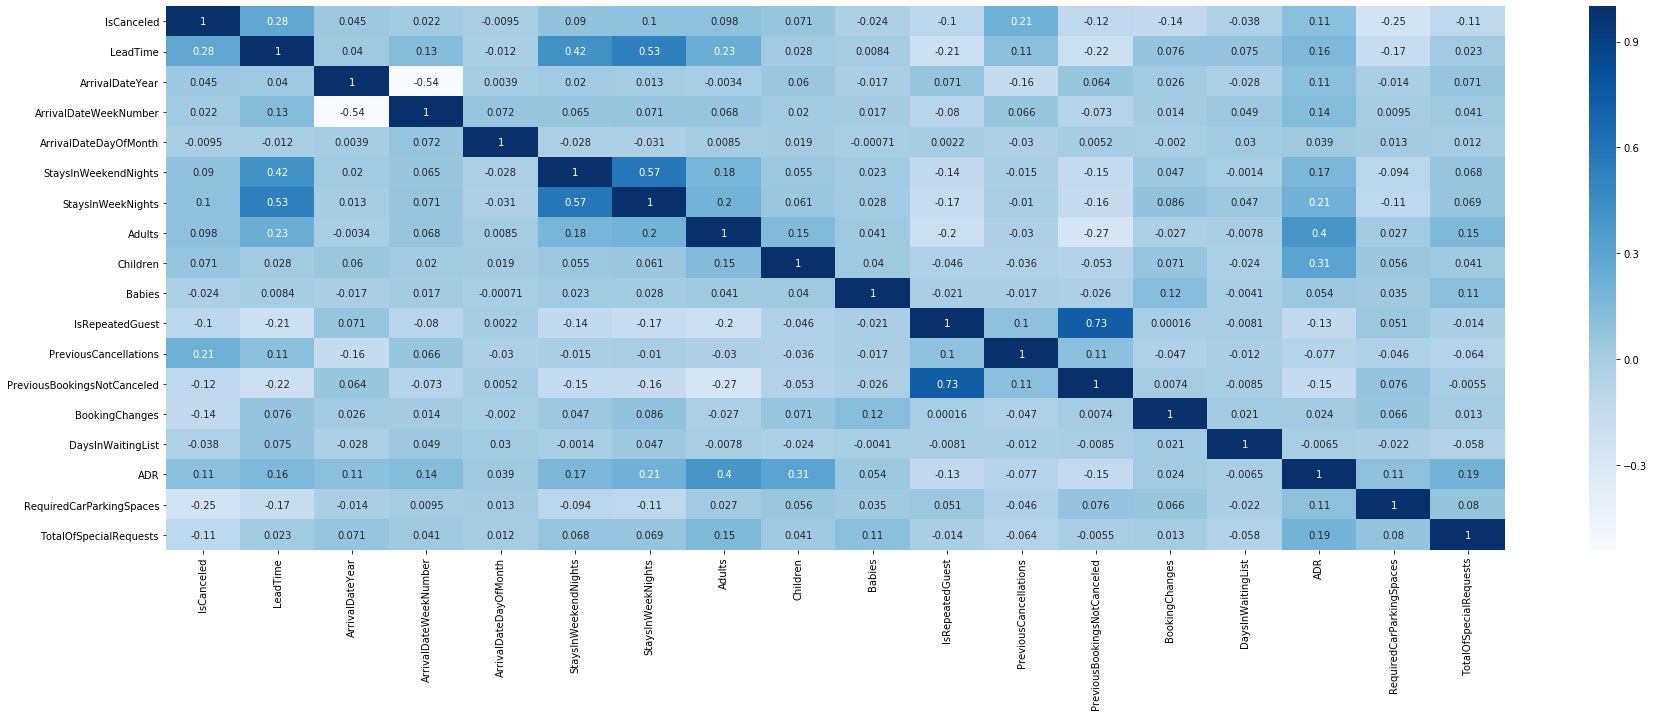

In [49]:
plt.figure(figsize=(30,10))

corr = train_df.corr(method='spearman')
sns.heatmap(corr, cmap="Blues", annot=True)

#### Checking the average influence of few categorical columns over some important variable such ADR, iscancelled

In [50]:
train_df.groupby('Country').mean()[['IsCanceled','ADR','StaysInWeekendNights','StaysInWeekNights']].sort_values(by='ADR',ascending=False)

,IsCanceled,ADR,StaysInWeekendNights,StaysInWeekNights
Country,,,,
SEN,1.000000,289.600000,3.0,7.000000
DJI,0.000000,273.000000,0.0,1.000000
AND,0.600000,245.714000,1.4,4.000000
GEO,0.636364,234.760909,2.0,3.818182
PER,0.000000,234.000000,0.0,1.000000
...,...,...,...,...
UGA,0.000000,43.000000,2.0,1.000000
CYM,0.000000,40.500000,1.0,3.000000
CRI,0.000000,36.260000,2.0,0.000000


In [51]:
train_df.groupby('Agent').mean()[['IsCanceled','ADR','StaysInWeekendNights','StaysInWeekNights']].sort_values(by='ADR',ascending=False)

,IsCanceled,ADR,StaysInWeekendNights,StaysInWeekNights
Agent,,,,
426,0.0,238.723333,2.000000,4.000000
433,0.0,193.600000,4.000000,9.000000
508,0.0,190.691667,1.333333,3.000000
414,0.0,179.000000,0.000000,2.000000
497,0.0,177.800000,4.000000,10.000000
...,...,...,...,...
367,0.0,21.000000,0.000000,4.000000
180,0.0,15.000000,0.000000,0.500000
187,0.0,14.000000,0.000000,2.000000


In [52]:
train_df.groupby('CustomerType').mean()[['IsCanceled','ADR','StaysInWeekendNights','StaysInWeekNights']].sort_values(by='ADR',ascending=False)

,IsCanceled,ADR,StaysInWeekendNights,StaysInWeekNights
CustomerType,,,,
Transient,0.311695,101.108248,1.158761,3.016717
Contract,0.088401,79.124966,2.448761,6.114302
Transient-Party,0.194969,75.430209,1.033243,2.912977
Group,0.105634,74.762711,0.915493,2.292254


In [53]:
train_df.groupby('DepositType').mean()[['IsCanceled','ADR','StaysInWeekendNights','StaysInWeekNights']].sort_values(by='ADR',ascending=False)

,IsCanceled,ADR,StaysInWeekendNights,StaysInWeekNights
DepositType,,,,
No Deposit,0.247389,96.335715,1.195948,3.143512
Refundable,0.154930,70.749507,0.936620,2.795775
Non Refund,0.959860,66.224532,1.074462,2.827807


### Performing Label Encoding , as it is much efficient in this case where few columns are having more catergories in their values

In [54]:
from sklearn.preprocessing import LabelEncoder
def label_encoding(data,cols):
    label_encoder = LabelEncoder()

    for col in cols:
        data[col]=label_encoder.fit_transform(data[col])
    return data


train_df_encoded=label_encoding(train_df,dtype_info["Categorical"])

In [55]:
train_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40060 entries, 0 to 40059
Data columns (total 30 columns):
IsCanceled                     40060 non-null int64
LeadTime                       40060 non-null int64
ArrivalDateYear                40060 non-null int64
ArrivalDateMonth               40060 non-null int64
ArrivalDateWeekNumber          40060 non-null int64
ArrivalDateDayOfMonth          40060 non-null int64
StaysInWeekendNights           40060 non-null int64
StaysInWeekNights              40060 non-null int64
Adults                         40060 non-null int64
Children                       40060 non-null int64
Babies                         40060 non-null int64
Meal                           40060 non-null int64
Country                        40060 non-null int64
MarketSegment                  40060 non-null int64
DistributionChannel            40060 non-null int64
IsRepeatedGuest                40060 non-null int64
PreviousCancellations          40060 non-null int64
Previou

#### Getting the Summary statistics for all the variables now

In [56]:
train_df_encoded.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,BookingChanges,DepositType,Agent,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
count,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,...,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.00000,40060.000000,40060.000000
mean,0.277634,92.675686,2016.121443,5.314553,27.140864,15.821243,1.189815,3.128732,1.867149,0.128682,...,0.287968,0.050000,60.591737,0.527758,2.098727,94.952930,0.138068,0.61977,0.736895,501.959436
std,0.447837,97.285315,0.722347,3.501621,14.005441,8.883708,1.147812,2.461329,0.697285,0.445195,...,0.726548,0.233647,36.834447,7.428580,0.607593,61.442418,0.351001,0.81393,0.456524,228.446748
min,0.000000,0.000000,2015.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,10.000000,2016.000000,2.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,47.000000,0.000000,2.000000,50.000000,0.000000,0.00000,0.000000,317.000000
50%,0.000000,57.000000,2016.000000,5.000000,28.000000,16.000000,1.000000,3.000000,2.000000,0.000000,...,0.000000,0.000000,47.000000,0.000000,2.000000,75.000000,0.000000,0.00000,1.000000,504.000000
75%,1.000000,155.000000,2017.000000,8.000000,38.000000,24.000000,2.000000,5.000000,2.000000,0.000000,...,0.000000,0.000000,55.000000,0.000000,2.000000,125.000000,0.000000,1.00000,1.000000,699.000000
max,1.000000,737.000000,2017.000000,11.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,...,17.000000,2.000000,184.000000,185.000000,3.000000,508.000000,8.000000,5.00000,2.000000,912.000000


#### here, I am not performing any dimensionality reduction as it will be hard to explain about the results with the shifted dimensions and instead going for feature selection

In [57]:
X=train_df_encoded.drop(['IsCanceled'],axis=1).values
y=train_df_encoded['IsCanceled'].values

In [58]:
print (X.shape,y.shape)

(40060, 29) (40060,)


### Outlier Detection

In [59]:
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

out_iqr(train_df_encoded,'IsCanceled')

The IQR is 1.0
The lower bound value is -1.5
The upper bound value is 2.5
Total number of outliers are 0


## Feature Selection

### Selecting the features based on the train set is always the best practise. Since our motivation here is to train the algorithm based on the data from H1 and test on H2, we are good in using the whole train set from H1 in selecting the features. However, if we want to perform train_test split directly on the h1 to test the other part of H1 as validation set, that is more accurate and logical.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.25,
    random_state=42)


# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=10,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   58.2s finished

[2021-04-17 21:37:53] Features: 1/10 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   51.2s finished

[2021-04-17 21:38:44] Features: 2/10 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   53.8s finished

[2021-04-17 21:39:38] Features: 3/10 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:  

In [62]:
## Feature indices for the selected the features
list(sfs1.k_feature_idx_)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 27]

In [63]:
train_df_pruned_features=train_df_encoded.iloc[:,list(sfs1.k_feature_idx_)]
train_df_pruned_features.head(10)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,TotalOfSpecialRequests
0,0,342,2015,5,27,1,0,0,2,0
1,0,737,2015,5,27,1,0,0,2,0
2,0,7,2015,5,27,1,0,1,1,0
3,0,13,2015,5,27,1,0,1,1,0
4,0,14,2015,5,27,1,0,2,2,1
5,0,14,2015,5,27,1,0,2,2,1
6,0,0,2015,5,27,1,0,2,2,0
7,0,9,2015,5,27,1,0,2,2,1
8,1,85,2015,5,27,1,0,3,2,1
9,1,75,2015,5,27,1,0,3,2,0


In [130]:
train_df_pruned_features.drop(['IsCanceled'],axis=1).columns

Index(['LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults',
       'TotalOfSpecialRequests'],
      dtype='object')

In [133]:
X_pruned=train_df_pruned_features.drop(['IsCanceled'],axis=1).values
X_train, X_test, y_train, y_test = train_test_split(
    X_pruned,y,
    test_size=0.25,
    random_state=42)


## Cross validation

In [134]:
def Cross_validate_model(model,X_pruned,y):

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_pruned, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

## Let's dive into Machine Learning--Since we are fitting a large dataset, we can make use of complex models and then use Ensembling to control overfitting

## XGBoost Classifier-with Hyperparameter tuning

In [135]:

parameters_xgb={
    'alpha':[5,8,10],
    'learning_rate':[0.005,0.01],
    'max_depth':[5,7],
    'min_child_weight':[6],
    'n_estimators':[3000],
    
}

xgb_model=GridSearchCV(xgb.XGBClassifier(),param_grid=parameters_xgb,n_jobs=-1,verbose=2)
xgb_model.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  9.6min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [5, 8, 10], 'learning_rate': [0.005, 0.01],
                         'max_depth': [5, 7], 'min_child_weight': [6],
               

### The final model after rounds of hyperparamter tuning is as below with the parameters

In [136]:
xgb_model.best_estimator_

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=6, missing=None, n_estimators=3000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [137]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions_score = model.score(X_train,y_train)
    y_pred = model.predict(X_train)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_train, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return accuracy
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions_score = model.score(X_test,y_test)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return accuracy
    
def calc_metrics(X_train, y_train, X_test, y_test,model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [138]:
calc_metrics(X_train,y_train,X_test,y_test,xgb_model.best_estimator_)

Accuracy: 83.71%
Accuracy: 79.27%


(0.8370777167581961, 0.7927109335996007)

In [139]:
y_pred=xgb_model.best_estimator_.predict(X_test)

In [140]:
y_test

array([0, 0, 1, ..., 0, 0, 0])

In [141]:
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [142]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[6823  426]
 [1650 1116]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      7249
           1       0.72      0.40      0.52      2766

    accuracy                           0.79     10015
   macro avg       0.76      0.67      0.69     10015
weighted avg       0.78      0.79      0.77     10015



In [143]:
Cross_validate_model(xgb_model.best_estimator_,X_pruned,y)

Accuracy: 0.795 (0.008)


### 100% accuracy both on the train and the validation set looks great right? To avoid deviations on our real test set-H2 data, I am building an ensemble network with LightGBM and CatBoost classifier as well.

## LightBGM Classifier

In [144]:
parameters_lgb={
    'learning_rate':[0.005,0.01],
    'max_depth':[5,7],
    'min_child_weight':[0.2],
    'n_estimators':[1000,1500]
    
}

lgb_model=GridSearchCV(lgb.LGBMClassifier(),param_grid=parameters_lgb,n_jobs=-1,verbose=2)
lgb_model.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   20.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   21.3s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.01], 'max_depth': [5, 7],
   

In [145]:
calc_metrics(X_train,y_train,X_test,y_test,lgb_model.best_estimator_)

Accuracy: 80.51%
Accuracy: 78.68%


(0.8050923614578133, 0.7868197703444832)

## Well, we have a rocking accuracy on the validation set from both the models, but I'd not take a chance and instead a build an ensemble by building a Stacker(with the meta-model as "CatBoost"

## CatBoost Classifier

### Unforutnately we aren't using the full capacity of catboost-where we can directly give the categorical features and it will deal with the labels. Since we are using it as meta-model, the labels are already encoded in the first stage

In [146]:
parameters_cb={
    'learning_rate':[0.005,0.01],
    'max_depth':[5,7],
    'n_estimators':[1000,1500],
    'random_strength':[10,25,60],
    'colsample_bylevel':[0.6,0.75]
}

cb_model=GridSearchCV(cb.CatBoostClassifier(),param_grid=parameters_cb,n_jobs=-1,verbose=2)
cb_model.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.9min finished


0:	learn: 0.6899651	total: 24.7ms	remaining: 37.1s
1:	learn: 0.6876852	total: 43.4ms	remaining: 32.5s
2:	learn: 0.6848789	total: 58.6ms	remaining: 29.3s
3:	learn: 0.6819730	total: 72.7ms	remaining: 27.2s
4:	learn: 0.6792202	total: 82.8ms	remaining: 24.7s
5:	learn: 0.6766900	total: 92.8ms	remaining: 23.1s
6:	learn: 0.6741648	total: 102ms	remaining: 21.6s
7:	learn: 0.6723600	total: 109ms	remaining: 20.2s
8:	learn: 0.6701471	total: 124ms	remaining: 20.6s
9:	learn: 0.6673517	total: 135ms	remaining: 20.1s
10:	learn: 0.6644089	total: 144ms	remaining: 19.5s
11:	learn: 0.6618658	total: 155ms	remaining: 19.2s
12:	learn: 0.6595133	total: 163ms	remaining: 18.7s
13:	learn: 0.6569227	total: 171ms	remaining: 18.2s
14:	learn: 0.6542429	total: 179ms	remaining: 17.8s
15:	learn: 0.6522745	total: 186ms	remaining: 17.2s
16:	learn: 0.6498959	total: 194ms	remaining: 16.9s
17:	learn: 0.6482266	total: 202ms	remaining: 16.6s
18:	learn: 0.6460546	total: 210ms	remaining: 16.4s
19:	learn: 0.6443892	total: 216ms	r

173:	learn: 0.5396051	total: 1.64s	remaining: 12.5s
174:	learn: 0.5393871	total: 1.65s	remaining: 12.5s
175:	learn: 0.5392351	total: 1.66s	remaining: 12.5s
176:	learn: 0.5391894	total: 1.67s	remaining: 12.5s
177:	learn: 0.5390260	total: 1.67s	remaining: 12.4s
178:	learn: 0.5389015	total: 1.69s	remaining: 12.4s
179:	learn: 0.5386333	total: 1.7s	remaining: 12.4s
180:	learn: 0.5383589	total: 1.7s	remaining: 12.4s
181:	learn: 0.5382597	total: 1.72s	remaining: 12.4s
182:	learn: 0.5382168	total: 1.72s	remaining: 12.4s
183:	learn: 0.5380621	total: 1.74s	remaining: 12.4s
184:	learn: 0.5378388	total: 1.75s	remaining: 12.4s
185:	learn: 0.5376972	total: 1.76s	remaining: 12.4s
186:	learn: 0.5375242	total: 1.77s	remaining: 12.4s
187:	learn: 0.5373164	total: 1.78s	remaining: 12.4s
188:	learn: 0.5371577	total: 1.8s	remaining: 12.5s
189:	learn: 0.5369694	total: 1.81s	remaining: 12.5s
190:	learn: 0.5368166	total: 1.82s	remaining: 12.5s
191:	learn: 0.5366519	total: 1.83s	remaining: 12.5s
192:	learn: 0.5

340:	learn: 0.5235169	total: 3.25s	remaining: 11s
341:	learn: 0.5234387	total: 3.26s	remaining: 11s
342:	learn: 0.5233518	total: 3.27s	remaining: 11s
343:	learn: 0.5232759	total: 3.28s	remaining: 11s
344:	learn: 0.5232267	total: 3.29s	remaining: 11s
345:	learn: 0.5232031	total: 3.29s	remaining: 11s
346:	learn: 0.5231554	total: 3.3s	remaining: 11s
347:	learn: 0.5231209	total: 3.31s	remaining: 11s
348:	learn: 0.5230715	total: 3.32s	remaining: 10.9s
349:	learn: 0.5230705	total: 3.32s	remaining: 10.9s
350:	learn: 0.5229971	total: 3.33s	remaining: 10.9s
351:	learn: 0.5229264	total: 3.34s	remaining: 10.9s
352:	learn: 0.5229139	total: 3.35s	remaining: 10.9s
353:	learn: 0.5228506	total: 3.35s	remaining: 10.9s
354:	learn: 0.5228125	total: 3.36s	remaining: 10.8s
355:	learn: 0.5227491	total: 3.37s	remaining: 10.8s
356:	learn: 0.5227320	total: 3.38s	remaining: 10.8s
357:	learn: 0.5226801	total: 3.39s	remaining: 10.8s
358:	learn: 0.5226397	total: 3.4s	remaining: 10.8s
359:	learn: 0.5226243	total: 3

499:	learn: 0.5156457	total: 4.63s	remaining: 9.26s
500:	learn: 0.5155632	total: 4.64s	remaining: 9.25s
501:	learn: 0.5155581	total: 4.65s	remaining: 9.24s
502:	learn: 0.5155126	total: 4.66s	remaining: 9.23s
503:	learn: 0.5155040	total: 4.67s	remaining: 9.22s
504:	learn: 0.5155023	total: 4.68s	remaining: 9.22s
505:	learn: 0.5154467	total: 4.69s	remaining: 9.21s
506:	learn: 0.5154450	total: 4.7s	remaining: 9.2s
507:	learn: 0.5154195	total: 4.71s	remaining: 9.19s
508:	learn: 0.5153996	total: 4.71s	remaining: 9.18s
509:	learn: 0.5153466	total: 4.72s	remaining: 9.17s
510:	learn: 0.5152306	total: 4.73s	remaining: 9.16s
511:	learn: 0.5151676	total: 4.74s	remaining: 9.15s
512:	learn: 0.5151160	total: 4.75s	remaining: 9.14s
513:	learn: 0.5150910	total: 4.76s	remaining: 9.13s
514:	learn: 0.5150399	total: 4.77s	remaining: 9.13s
515:	learn: 0.5149856	total: 4.78s	remaining: 9.11s
516:	learn: 0.5149600	total: 4.79s	remaining: 9.1s
517:	learn: 0.5149331	total: 4.8s	remaining: 9.09s
518:	learn: 0.51

669:	learn: 0.5097616	total: 6.02s	remaining: 7.46s
670:	learn: 0.5097456	total: 6.03s	remaining: 7.45s
671:	learn: 0.5097424	total: 6.03s	remaining: 7.43s
672:	learn: 0.5096819	total: 6.04s	remaining: 7.42s
673:	learn: 0.5096581	total: 6.05s	remaining: 7.42s
674:	learn: 0.5096494	total: 6.06s	remaining: 7.41s
675:	learn: 0.5096073	total: 6.07s	remaining: 7.39s
676:	learn: 0.5096020	total: 6.07s	remaining: 7.38s
677:	learn: 0.5095740	total: 6.08s	remaining: 7.37s
678:	learn: 0.5095261	total: 6.09s	remaining: 7.36s
679:	learn: 0.5094655	total: 6.1s	remaining: 7.36s
680:	learn: 0.5093741	total: 6.11s	remaining: 7.35s
681:	learn: 0.5093206	total: 6.12s	remaining: 7.34s
682:	learn: 0.5092773	total: 6.13s	remaining: 7.33s
683:	learn: 0.5092645	total: 6.14s	remaining: 7.32s
684:	learn: 0.5092041	total: 6.15s	remaining: 7.32s
685:	learn: 0.5091911	total: 6.16s	remaining: 7.31s
686:	learn: 0.5091084	total: 6.17s	remaining: 7.3s
687:	learn: 0.5090822	total: 6.17s	remaining: 7.29s
688:	learn: 0.

849:	learn: 0.5043559	total: 7.42s	remaining: 5.68s
850:	learn: 0.5043444	total: 7.43s	remaining: 5.67s
851:	learn: 0.5043161	total: 7.44s	remaining: 5.66s
852:	learn: 0.5043016	total: 7.45s	remaining: 5.65s
853:	learn: 0.5042977	total: 7.46s	remaining: 5.64s
854:	learn: 0.5042710	total: 7.46s	remaining: 5.63s
855:	learn: 0.5042163	total: 7.47s	remaining: 5.62s
856:	learn: 0.5041842	total: 7.48s	remaining: 5.61s
857:	learn: 0.5041824	total: 7.48s	remaining: 5.6s
858:	learn: 0.5041481	total: 7.49s	remaining: 5.59s
859:	learn: 0.5041438	total: 7.5s	remaining: 5.58s
860:	learn: 0.5040977	total: 7.5s	remaining: 5.57s
861:	learn: 0.5040806	total: 7.51s	remaining: 5.56s
862:	learn: 0.5040727	total: 7.52s	remaining: 5.55s
863:	learn: 0.5040529	total: 7.53s	remaining: 5.54s
864:	learn: 0.5040346	total: 7.53s	remaining: 5.53s
865:	learn: 0.5040246	total: 7.54s	remaining: 5.52s
866:	learn: 0.5040164	total: 7.55s	remaining: 5.51s
867:	learn: 0.5039898	total: 7.55s	remaining: 5.5s
868:	learn: 0.50

1008:	learn: 0.5003482	total: 8.82s	remaining: 4.29s
1009:	learn: 0.5003221	total: 8.83s	remaining: 4.28s
1010:	learn: 0.5003079	total: 8.84s	remaining: 4.28s
1011:	learn: 0.5002564	total: 8.85s	remaining: 4.27s
1012:	learn: 0.5002474	total: 8.86s	remaining: 4.26s
1013:	learn: 0.5002226	total: 8.87s	remaining: 4.25s
1014:	learn: 0.5001940	total: 8.88s	remaining: 4.24s
1015:	learn: 0.5001622	total: 8.89s	remaining: 4.23s
1016:	learn: 0.5001544	total: 8.9s	remaining: 4.22s
1017:	learn: 0.5000900	total: 8.91s	remaining: 4.22s
1018:	learn: 0.5000687	total: 8.92s	remaining: 4.21s
1019:	learn: 0.5000527	total: 8.93s	remaining: 4.2s
1020:	learn: 0.5000494	total: 8.93s	remaining: 4.19s
1021:	learn: 0.5000218	total: 8.94s	remaining: 4.18s
1022:	learn: 0.4999670	total: 8.95s	remaining: 4.17s
1023:	learn: 0.4999257	total: 8.96s	remaining: 4.17s
1024:	learn: 0.4998743	total: 8.97s	remaining: 4.16s
1025:	learn: 0.4998628	total: 8.98s	remaining: 4.15s
1026:	learn: 0.4998459	total: 8.99s	remaining: 4

1171:	learn: 0.4942934	total: 10.4s	remaining: 2.92s
1172:	learn: 0.4942325	total: 10.4s	remaining: 2.91s
1173:	learn: 0.4942045	total: 10.5s	remaining: 2.9s
1174:	learn: 0.4941198	total: 10.5s	remaining: 2.89s
1175:	learn: 0.4940875	total: 10.5s	remaining: 2.88s
1176:	learn: 0.4940542	total: 10.5s	remaining: 2.88s
1177:	learn: 0.4940244	total: 10.5s	remaining: 2.87s
1178:	learn: 0.4939423	total: 10.5s	remaining: 2.86s
1179:	learn: 0.4938913	total: 10.5s	remaining: 2.85s
1180:	learn: 0.4938456	total: 10.5s	remaining: 2.84s
1181:	learn: 0.4938215	total: 10.5s	remaining: 2.83s
1182:	learn: 0.4937924	total: 10.5s	remaining: 2.83s
1183:	learn: 0.4937019	total: 10.6s	remaining: 2.82s
1184:	learn: 0.4936483	total: 10.6s	remaining: 2.81s
1185:	learn: 0.4935918	total: 10.6s	remaining: 2.8s
1186:	learn: 0.4935512	total: 10.6s	remaining: 2.79s
1187:	learn: 0.4934990	total: 10.6s	remaining: 2.78s
1188:	learn: 0.4934137	total: 10.6s	remaining: 2.77s
1189:	learn: 0.4934042	total: 10.6s	remaining: 2

1332:	learn: 0.4844157	total: 12.1s	remaining: 1.51s
1333:	learn: 0.4843608	total: 12.1s	remaining: 1.5s
1334:	learn: 0.4842877	total: 12.1s	remaining: 1.49s
1335:	learn: 0.4842586	total: 12.1s	remaining: 1.48s
1336:	learn: 0.4841719	total: 12.1s	remaining: 1.47s
1337:	learn: 0.4840930	total: 12.1s	remaining: 1.47s
1338:	learn: 0.4840704	total: 12.1s	remaining: 1.46s
1339:	learn: 0.4839595	total: 12.1s	remaining: 1.45s
1340:	learn: 0.4839295	total: 12.1s	remaining: 1.44s
1341:	learn: 0.4838495	total: 12.2s	remaining: 1.43s
1342:	learn: 0.4837729	total: 12.2s	remaining: 1.42s
1343:	learn: 0.4837230	total: 12.2s	remaining: 1.41s
1344:	learn: 0.4836334	total: 12.2s	remaining: 1.4s
1345:	learn: 0.4836018	total: 12.2s	remaining: 1.4s
1346:	learn: 0.4835374	total: 12.2s	remaining: 1.39s
1347:	learn: 0.4835009	total: 12.2s	remaining: 1.38s
1348:	learn: 0.4834417	total: 12.2s	remaining: 1.37s
1349:	learn: 0.4833844	total: 12.3s	remaining: 1.36s
1350:	learn: 0.4833366	total: 12.3s	remaining: 1.

1488:	learn: 0.4756349	total: 13.5s	remaining: 99.4ms
1489:	learn: 0.4755619	total: 13.5s	remaining: 90.4ms
1490:	learn: 0.4754687	total: 13.5s	remaining: 81.3ms
1491:	learn: 0.4754132	total: 13.5s	remaining: 72.3ms
1492:	learn: 0.4753507	total: 13.5s	remaining: 63.3ms
1493:	learn: 0.4753008	total: 13.5s	remaining: 54.2ms
1494:	learn: 0.4752680	total: 13.5s	remaining: 45.2ms
1495:	learn: 0.4752101	total: 13.5s	remaining: 36.2ms
1496:	learn: 0.4751578	total: 13.5s	remaining: 27.1ms
1497:	learn: 0.4751154	total: 13.5s	remaining: 18.1ms
1498:	learn: 0.4750710	total: 13.5s	remaining: 9.04ms
1499:	learn: 0.4750219	total: 13.6s	remaining: 0us


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc755701bd0>,
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bylevel': [0.6, 0.75],
                         'learning_rate': [0.005, 0.01], 'max_depth': [5, 7],
                         'n_estimators': [1000, 1500],
                         'random_strength': [10, 25, 60]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [147]:
calc_metrics(X_train,y_train,X_test,y_test,cb_model.best_estimator_)

Accuracy: 77.93%
Accuracy: 77.39%


(0.7792977200865369, 0.7739390913629556)

In [148]:
Cross_validate_model(cb_model.best_estimator_,X_pruned,y)

Accuracy: 0.771 (0.007)


## Stacking Models 

In [172]:
class StackingAveragedModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [150]:
stacked_averaged_models = StackingAveragedModels(base_models = (xgb_model.best_estimator_, lgb_model.best_estimator_),
                                                 meta_model = cb_model.best_estimator_)


In [151]:
stacked_averaged_models.fit(X_train,y_train)

0:	learn: 0.6891674	total: 5.23ms	remaining: 7.84s
1:	learn: 0.6856087	total: 13.4ms	remaining: 10s
2:	learn: 0.6817909	total: 18.7ms	remaining: 9.34s
3:	learn: 0.6783838	total: 23.6ms	remaining: 8.83s
4:	learn: 0.6764609	total: 27.6ms	remaining: 8.26s
5:	learn: 0.6729194	total: 32.5ms	remaining: 8.08s
6:	learn: 0.6696943	total: 37.1ms	remaining: 7.92s
7:	learn: 0.6662199	total: 41.5ms	remaining: 7.74s
8:	learn: 0.6628205	total: 46.1ms	remaining: 7.63s
9:	learn: 0.6595667	total: 50.6ms	remaining: 7.53s
10:	learn: 0.6578858	total: 54ms	remaining: 7.32s
11:	learn: 0.6549644	total: 58.6ms	remaining: 7.26s
12:	learn: 0.6518772	total: 63.2ms	remaining: 7.23s
13:	learn: 0.6488566	total: 67.1ms	remaining: 7.12s
14:	learn: 0.6473189	total: 70.5ms	remaining: 6.98s
15:	learn: 0.6443287	total: 75.6ms	remaining: 7.01s
16:	learn: 0.6414031	total: 79.8ms	remaining: 6.96s
17:	learn: 0.6399643	total: 83.6ms	remaining: 6.88s
18:	learn: 0.6374038	total: 87.2ms	remaining: 6.8s
19:	learn: 0.6346286	total:

177:	learn: 0.5146733	total: 785ms	remaining: 5.83s
178:	learn: 0.5146280	total: 789ms	remaining: 5.83s
179:	learn: 0.5144961	total: 794ms	remaining: 5.82s
180:	learn: 0.5143632	total: 799ms	remaining: 5.82s
181:	learn: 0.5142330	total: 804ms	remaining: 5.82s
182:	learn: 0.5141091	total: 809ms	remaining: 5.82s
183:	learn: 0.5139876	total: 813ms	remaining: 5.82s
184:	learn: 0.5138652	total: 817ms	remaining: 5.81s
185:	learn: 0.5137453	total: 821ms	remaining: 5.8s
186:	learn: 0.5136279	total: 825ms	remaining: 5.79s
187:	learn: 0.5135130	total: 830ms	remaining: 5.79s
188:	learn: 0.5134004	total: 835ms	remaining: 5.79s
189:	learn: 0.5132900	total: 839ms	remaining: 5.78s
190:	learn: 0.5131983	total: 843ms	remaining: 5.78s
191:	learn: 0.5130951	total: 846ms	remaining: 5.77s
192:	learn: 0.5130069	total: 851ms	remaining: 5.76s
193:	learn: 0.5129206	total: 855ms	remaining: 5.75s
194:	learn: 0.5128360	total: 859ms	remaining: 5.75s
195:	learn: 0.5128041	total: 862ms	remaining: 5.73s
196:	learn: 0

357:	learn: 0.5083007	total: 1.56s	remaining: 4.97s
358:	learn: 0.5082944	total: 1.56s	remaining: 4.97s
359:	learn: 0.5082882	total: 1.57s	remaining: 4.96s
360:	learn: 0.5082821	total: 1.57s	remaining: 4.96s
361:	learn: 0.5082762	total: 1.58s	remaining: 4.96s
362:	learn: 0.5082703	total: 1.58s	remaining: 4.96s
363:	learn: 0.5082646	total: 1.59s	remaining: 4.95s
364:	learn: 0.5082590	total: 1.59s	remaining: 4.95s
365:	learn: 0.5082535	total: 1.59s	remaining: 4.94s
366:	learn: 0.5082481	total: 1.6s	remaining: 4.94s
367:	learn: 0.5082429	total: 1.6s	remaining: 4.93s
368:	learn: 0.5082377	total: 1.61s	remaining: 4.93s
369:	learn: 0.5082327	total: 1.61s	remaining: 4.92s
370:	learn: 0.5082277	total: 1.62s	remaining: 4.92s
371:	learn: 0.5082228	total: 1.62s	remaining: 4.92s
372:	learn: 0.5082181	total: 1.63s	remaining: 4.91s
373:	learn: 0.5082134	total: 1.63s	remaining: 4.91s
374:	learn: 0.5082089	total: 1.63s	remaining: 4.9s
375:	learn: 0.5082044	total: 1.64s	remaining: 4.9s
376:	learn: 0.50

563:	learn: 0.5079967	total: 2.33s	remaining: 3.86s
564:	learn: 0.5079965	total: 2.33s	remaining: 3.85s
565:	learn: 0.5079965	total: 2.33s	remaining: 3.85s
566:	learn: 0.5079962	total: 2.34s	remaining: 3.85s
567:	learn: 0.5079960	total: 2.34s	remaining: 3.84s
568:	learn: 0.5079958	total: 2.34s	remaining: 3.83s
569:	learn: 0.5079955	total: 2.35s	remaining: 3.83s
570:	learn: 0.5079953	total: 2.35s	remaining: 3.83s
571:	learn: 0.5079952	total: 2.35s	remaining: 3.82s
572:	learn: 0.5079950	total: 2.36s	remaining: 3.81s
573:	learn: 0.5079949	total: 2.36s	remaining: 3.81s
574:	learn: 0.5079946	total: 2.37s	remaining: 3.8s
575:	learn: 0.5079944	total: 2.37s	remaining: 3.8s
576:	learn: 0.5079942	total: 2.37s	remaining: 3.79s
577:	learn: 0.5079941	total: 2.37s	remaining: 3.79s
578:	learn: 0.5079939	total: 2.38s	remaining: 3.78s
579:	learn: 0.5079938	total: 2.38s	remaining: 3.78s
580:	learn: 0.5079938	total: 2.38s	remaining: 3.77s
581:	learn: 0.5079937	total: 2.39s	remaining: 3.77s
582:	learn: 0.

747:	learn: 0.5079877	total: 2.89s	remaining: 2.91s
748:	learn: 0.5079877	total: 2.9s	remaining: 2.9s
749:	learn: 0.5079877	total: 2.9s	remaining: 2.9s
750:	learn: 0.5079877	total: 2.9s	remaining: 2.9s
751:	learn: 0.5079877	total: 2.91s	remaining: 2.89s
752:	learn: 0.5079877	total: 2.91s	remaining: 2.89s
753:	learn: 0.5079877	total: 2.92s	remaining: 2.88s
754:	learn: 0.5079877	total: 2.92s	remaining: 2.88s
755:	learn: 0.5079877	total: 2.92s	remaining: 2.88s
756:	learn: 0.5079877	total: 2.92s	remaining: 2.87s
757:	learn: 0.5079877	total: 2.93s	remaining: 2.87s
758:	learn: 0.5079877	total: 2.93s	remaining: 2.86s
759:	learn: 0.5079877	total: 2.94s	remaining: 2.86s
760:	learn: 0.5079877	total: 2.94s	remaining: 2.85s
761:	learn: 0.5079877	total: 2.94s	remaining: 2.85s
762:	learn: 0.5079877	total: 2.94s	remaining: 2.84s
763:	learn: 0.5079877	total: 2.95s	remaining: 2.84s
764:	learn: 0.5079877	total: 2.95s	remaining: 2.84s
765:	learn: 0.5079877	total: 2.96s	remaining: 2.83s
766:	learn: 0.5079

943:	learn: 0.5079877	total: 3.46s	remaining: 2.04s
944:	learn: 0.5079877	total: 3.46s	remaining: 2.03s
945:	learn: 0.5079877	total: 3.46s	remaining: 2.03s
946:	learn: 0.5079877	total: 3.47s	remaining: 2.02s
947:	learn: 0.5079877	total: 3.47s	remaining: 2.02s
948:	learn: 0.5079877	total: 3.48s	remaining: 2.02s
949:	learn: 0.5079877	total: 3.48s	remaining: 2.01s
950:	learn: 0.5079877	total: 3.48s	remaining: 2.01s
951:	learn: 0.5079877	total: 3.49s	remaining: 2.01s
952:	learn: 0.5079877	total: 3.49s	remaining: 2s
953:	learn: 0.5079877	total: 3.49s	remaining: 2s
954:	learn: 0.5079877	total: 3.5s	remaining: 2s
955:	learn: 0.5079877	total: 3.5s	remaining: 1.99s
956:	learn: 0.5079877	total: 3.5s	remaining: 1.99s
957:	learn: 0.5079877	total: 3.5s	remaining: 1.98s
958:	learn: 0.5079877	total: 3.51s	remaining: 1.98s
959:	learn: 0.5079877	total: 3.51s	remaining: 1.98s
960:	learn: 0.5079877	total: 3.52s	remaining: 1.97s
961:	learn: 0.5079877	total: 3.52s	remaining: 1.97s
962:	learn: 0.5079877	tot

1114:	learn: 0.5079877	total: 4.03s	remaining: 1.39s
1115:	learn: 0.5079877	total: 4.03s	remaining: 1.39s
1116:	learn: 0.5079877	total: 4.04s	remaining: 1.38s
1117:	learn: 0.5079877	total: 4.04s	remaining: 1.38s
1118:	learn: 0.5079877	total: 4.04s	remaining: 1.38s
1119:	learn: 0.5079877	total: 4.05s	remaining: 1.37s
1120:	learn: 0.5079877	total: 4.05s	remaining: 1.37s
1121:	learn: 0.5079877	total: 4.05s	remaining: 1.37s
1122:	learn: 0.5079877	total: 4.06s	remaining: 1.36s
1123:	learn: 0.5079877	total: 4.06s	remaining: 1.36s
1124:	learn: 0.5079877	total: 4.06s	remaining: 1.35s
1125:	learn: 0.5079877	total: 4.07s	remaining: 1.35s
1126:	learn: 0.5079877	total: 4.07s	remaining: 1.35s
1127:	learn: 0.5079877	total: 4.07s	remaining: 1.34s
1128:	learn: 0.5079877	total: 4.08s	remaining: 1.34s
1129:	learn: 0.5079877	total: 4.08s	remaining: 1.34s
1130:	learn: 0.5079877	total: 4.08s	remaining: 1.33s
1131:	learn: 0.5079877	total: 4.09s	remaining: 1.33s
1132:	learn: 0.5079877	total: 4.09s	remaining:

1309:	learn: 0.5079877	total: 4.59s	remaining: 667ms
1310:	learn: 0.5079877	total: 4.6s	remaining: 663ms
1311:	learn: 0.5079877	total: 4.6s	remaining: 659ms
1312:	learn: 0.5079877	total: 4.61s	remaining: 656ms
1313:	learn: 0.5079877	total: 4.61s	remaining: 652ms
1314:	learn: 0.5079877	total: 4.61s	remaining: 649ms
1315:	learn: 0.5079877	total: 4.62s	remaining: 646ms
1316:	learn: 0.5079877	total: 4.62s	remaining: 642ms
1317:	learn: 0.5079877	total: 4.63s	remaining: 639ms
1318:	learn: 0.5079877	total: 4.63s	remaining: 635ms
1319:	learn: 0.5079877	total: 4.63s	remaining: 632ms
1320:	learn: 0.5079877	total: 4.63s	remaining: 628ms
1321:	learn: 0.5079877	total: 4.64s	remaining: 625ms
1322:	learn: 0.5079877	total: 4.64s	remaining: 621ms
1323:	learn: 0.5079877	total: 4.65s	remaining: 618ms
1324:	learn: 0.5079877	total: 4.65s	remaining: 614ms
1325:	learn: 0.5079877	total: 4.65s	remaining: 611ms
1326:	learn: 0.5079877	total: 4.66s	remaining: 607ms
1327:	learn: 0.5079877	total: 4.66s	remaining: 6

1485:	learn: 0.5079877	total: 5.17s	remaining: 48.7ms
1486:	learn: 0.5079877	total: 5.17s	remaining: 45.2ms
1487:	learn: 0.5079877	total: 5.17s	remaining: 41.7ms
1488:	learn: 0.5079877	total: 5.18s	remaining: 38.2ms
1489:	learn: 0.5079877	total: 5.18s	remaining: 34.8ms
1490:	learn: 0.5079877	total: 5.18s	remaining: 31.3ms
1491:	learn: 0.5079877	total: 5.18s	remaining: 27.8ms
1492:	learn: 0.5079877	total: 5.19s	remaining: 24.3ms
1493:	learn: 0.5079877	total: 5.19s	remaining: 20.9ms
1494:	learn: 0.5079877	total: 5.19s	remaining: 17.4ms
1495:	learn: 0.5079877	total: 5.2s	remaining: 13.9ms
1496:	learn: 0.5079877	total: 5.2s	remaining: 10.4ms
1497:	learn: 0.5079877	total: 5.2s	remaining: 6.95ms
1498:	learn: 0.5079877	total: 5.2s	remaining: 3.47ms
1499:	learn: 0.5079877	total: 5.21s	remaining: 0us


StackingAveragedModels(base_models=(XGBClassifier(alpha=5, base_score=0.5,
                                                  booster='gbtree',
                                                  colsample_bylevel=1,
                                                  colsample_bynode=1,
                                                  colsample_bytree=1, gamma=0,
                                                  learning_rate=0.01,
                                                  max_delta_step=0, max_depth=7,
                                                  min_child_weight=6,
                                                  missing=None,
                                                  n_estimators=3000, n_jobs=1,
                                                  nthread=None,
                                                  objective='binary:logistic',
                                                  random_state=0, reg_alpha=0,
                                                  r

In [152]:
calc_metrics(X_train,y_train,X_test,y_test,stacked_averaged_models)

Accuracy: 83.44%
Accuracy: 79.34%


(0.8344150441005159, 0.7934098851722416)

In [153]:
Cross_validate_model(stacked_averaged_models,X_pruned,y)

Accuracy: 0.795 (0.007)


In [181]:
'''y_pred=stacked_averaged_models.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_h2,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="H2 hotel data , auc="+str(auc))
plt.legend(loc=4)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC-AUC Curve')
plt.show()'''

'y_pred=stacked_averaged_models.predict(X_test)\nfpr, tpr, _ = metrics.roc_curve(y_h2,  y_pred)\nauc = metrics.roc_auc_score(y_test, y_pred)\nplt.plot(fpr,tpr,label="H2 hotel data , auc="+str(auc))\nplt.legend(loc=4)\nplt.ylabel(\'TPR\')\nplt.xlabel(\'FPR\')\nplt.title(\'ROC-AUC Curve\')\nplt.show()'

## Now it's time to test the the complex ensemble we have in ordering to predict the 
Let's repeat the whole process now in lesser steps

In [155]:
## Reading the Hotel1 data
test_df = pd.read_csv('hotel-modelling-master/H2.csv')

test_df.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,...,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,August,35,31,2,5,3,0.0,...,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,August,35,31,2,5,2,0.0,...,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,August,35,31,2,5,2,0.0,...,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [156]:
train_df.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,BookingChanges,DepositType,Agent,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
count,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,...,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.00000,40060.000000,40060.000000
mean,0.277634,92.675686,2016.121443,5.314553,27.140864,15.821243,1.189815,3.128732,1.867149,0.128682,...,0.287968,0.050000,60.591737,0.527758,2.098727,94.952930,0.138068,0.61977,0.736895,501.959436
std,0.447837,97.285315,0.722347,3.501621,14.005441,8.883708,1.147812,2.461329,0.697285,0.445195,...,0.726548,0.233647,36.834447,7.428580,0.607593,61.442418,0.351001,0.81393,0.456524,228.446748
min,0.000000,0.000000,2015.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,10.000000,2016.000000,2.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,47.000000,0.000000,2.000000,50.000000,0.000000,0.00000,0.000000,317.000000
50%,0.000000,57.000000,2016.000000,5.000000,28.000000,16.000000,1.000000,3.000000,2.000000,0.000000,...,0.000000,0.000000,47.000000,0.000000,2.000000,75.000000,0.000000,0.00000,1.000000,504.000000
75%,1.000000,155.000000,2017.000000,8.000000,38.000000,24.000000,2.000000,5.000000,2.000000,0.000000,...,0.000000,0.000000,55.000000,0.000000,2.000000,125.000000,0.000000,1.00000,1.000000,699.000000
max,1.000000,737.000000,2017.000000,11.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,...,17.000000,2.000000,184.000000,185.000000,3.000000,508.000000,8.000000,5.00000,2.000000,912.000000


In [157]:
unique_entries_per_col(test_df)

Feature : IsCanceled and unique entries: [0 1]


Feature : LeadTime and unique entries: [  6  88  65  92 100  79   3  63  62  43   4  97  80  60 106  68  18  71
  85  75  89  83  72 111  86  73  55  69  76  61  77  54  90 117 105  51
  24  84 115  67  87 109  96 114  66  59 122 123  94 120   0 125  82 107
 103  12 118 108 119  20  22  99 112  93 132 110   2  15  98 124  16  19
  81   5  27  25 126  74   1  64 138 102  78 130 135   7  28  34 141  33
 101  13  11  36 128  30 145 142  39 121 147 140 104  41 134 150   8 133
  10  40 131   9 137 127  46  47  14 151  17  44 113  53  50 162 148 149
  21  23  37  49  26  32  52 173  45 164  42  58  48 168  31  38 175 170
  29  35 167 166  56 152 155 116  95  57 179  70 192 169 193 199 204 200
  91 198 158 210 156 174 184 180 195 216 233 212 139 242 208 146 144 159
 197 129 160 154 393 251 157 161 136 182 267 274 268 190 281 188 275 270
 265 288 143 295 443 194 437 253 207 302 259 178 289 298 286 309 196 273
 276 297 191 451 217 323 316 189 322

In [158]:
test_df_pruned=test_df[list(train_df_pruned_features.columns)]

In [159]:
test_df_pruned.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults',
       'TotalOfSpecialRequests'],
      dtype='object')

In [160]:
Null_value_checker(test_df_pruned)

False

In [161]:
dtype_test=numerical_categorical(test_df_pruned)
test_df_encoded_pruned=label_encoding(test_df_pruned,dtype_test["Categorical"])

In [162]:
test_df_encoded_pruned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 10 columns):
IsCanceled                79330 non-null int64
LeadTime                  79330 non-null int64
ArrivalDateYear           79330 non-null int64
ArrivalDateMonth          79330 non-null int64
ArrivalDateWeekNumber     79330 non-null int64
ArrivalDateDayOfMonth     79330 non-null int64
StaysInWeekendNights      79330 non-null int64
StaysInWeekNights         79330 non-null int64
Adults                    79330 non-null int64
TotalOfSpecialRequests    79330 non-null int64
dtypes: int64(10)
memory usage: 6.1 MB


In [163]:
X_h2=test_df_encoded_pruned.drop(['IsCanceled'],axis=1).values
y_h2=test_df_encoded_pruned['IsCanceled'].values

In [164]:
X_pruned.shape

(40060, 9)

In [165]:
X_h2.shape

(79330, 9)

In [166]:
y_h2_pred=stacked_averaged_models.predict(X_h2)

In [168]:
y_h2_pred

array([0, 0, 0, ..., 0, 0, 0])

In [169]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_h2,y_h2_pred))
print(classification_report(y_h2,y_h2_pred))

[[39936  6292]
 [20596 12506]]
              precision    recall  f1-score   support

           0       0.66      0.86      0.75     46228
           1       0.67      0.38      0.48     33102

    accuracy                           0.66     79330
   macro avg       0.66      0.62      0.62     79330
weighted avg       0.66      0.66      0.64     79330



In [170]:
calc_validation_error(X_h2,y_h2,stacked_averaged_models)

Accuracy: 66.11%


0.6610613891339973

In [174]:
test_df_encoded_pruned['IsCanceled'].value_counts()

0    46228
1    33102
Name: IsCanceled, dtype: int64

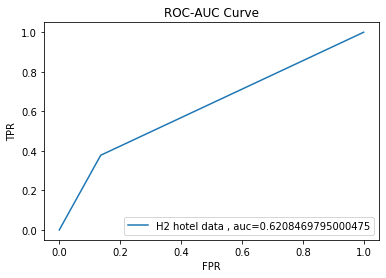

In [179]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_h2,  y_h2_pred)
auc = metrics.roc_auc_score(y_h2, y_h2_pred)
plt.plot(fpr,tpr,label="H2 hotel data , auc="+str(auc))
plt.legend(loc=4)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC-AUC Curve')
plt.show()

### Looking at the ROC-AUC curve above we, can say that the classifier trained on H1 hotel data is skillful to an extent, but might not be readily applicable for the data on H2

#### Now saving the Model into pickle file to using it for deployment

In [185]:
import joblib
joblib.dump(xgb_model.best_estimator_, 'HotelClassifierforcancellation.pkl')


['HotelClassifierforcancellation.pkl']

In [186]:
import joblib
joblib.dump(lgb_model.best_estimator_, 'HotelClassifierforcancellation_LGB.pkl')



['HotelClassifierforcancellation_LGB.pkl']

In [187]:
import joblib
joblib.dump(cb_model.best_estimator_, 'HotelClassifierforcancellatio_CB.pkl')



['HotelClassifierforcancellatio_CB.pkl']

In [190]:
stacked_averaged_models.meta_model_

In [191]:
s='}'

In [192]:
s[-1]

'}'

In [195]:
d1={'e':0}
d2={'e':0,'f':1}

if d1==d2:
    print('y')
else:
    print ('False')

False


In [197]:
i=['h','h','h','h']
if min(i)!=max(i):
    print ('y')


In [199]:
max(i)

'h'